In [1]:
import hnswlib
import numpy as np
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

In [2]:
from rpy2.robjects import r

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(3000, 3000, 3000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]


Transforming to str index.
... storing 'cells' as categorical
... storing 'batch' as categorical


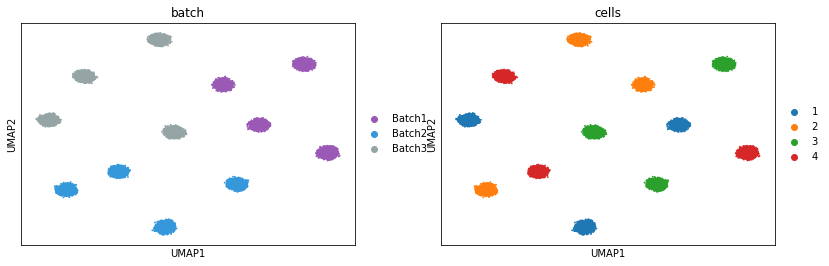

In [6]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
adata.uns["batch_colors"] = ["#9b59b6", "#3498db", "#95a5a6"]
sc.pl.umap(adata,color=['batch','cells'])

In [7]:
from bbtnn.tnn_v3 import *

In [8]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 2, save_on_disk = False, approx = False)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
new function
new function
Processing datasets (0, 2)
new function
new function
Processing datasets (1, 2)
new function
new function
2460 cells defined as MNNs
Calculating KNNs
1540 cells defined as KNNs
Re-format


W0330 14:05:20.930880 16224 deprecation.py:323] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0330 14:05:21.086121 16224 deprecation.py:506] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training neural network
Epoch 1/1000
125/125 - 4s - loss: 1.5515
Epoch 2/1000
125/125 - 2s - loss: 1.1985
Epoch 3/1000
125/125 - 2s - loss: 1.0337
Epoch 4/1000
125/125 - 2s - loss: 0.8469
Epoch 5/1000
125/125 - 2s - loss: 0.7354
Epoch 6/1000
125/125 - 2s - loss: 0.6484
Epoch 7/1000
125/125 - 2s - loss: 0.5813
Epoch 8/1000
125/125 - 2s - loss: 0.5038
Epoch 9/1000
125/125 - 2s - loss: 0.4476
Epoch 10/1000
125/125 - 2s - loss: 0.4144
Epoch 11/1000
125/125 - 2s - loss: 0.4272
Epoch 12/1000
125/125 - 2s - loss: 0.3945
Epoch 13/1000
125/125 - 2s - loss: 0.3785
Epoch 14/1000
125/125 - 2s - loss: 0.3832
Epoch 15/1000
125/125 - 2s - loss: 0.3862
4000/4000 - 0s
Wall time: 34.7 s


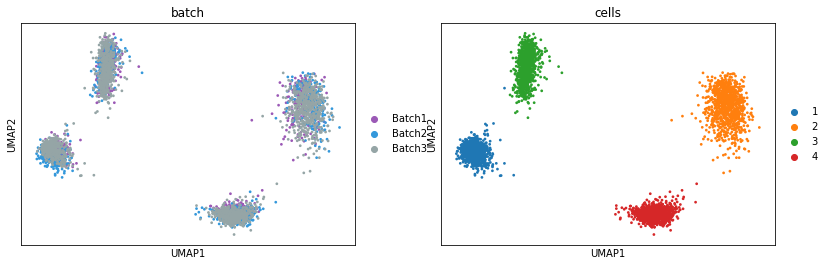

In [9]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "cells"])

In [104]:
from bbtnn.tnn_v2 import *

In [105]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]
******Total number of cells:9000
******Number of cells for MNN:3978
******Number of cells for KNN:5022
Sort cells
Wall time: 1min 28s


In [102]:
from bbtnn.tnn import *

In [103]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
model.fit(X = adata, Y = None)
embedding = model.transform(X = adata)

[[0.         0.261      0.26533333]
 [0.         0.         0.256     ]
 [0.         0.         0.        ]]
5299
******Batches:[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]
******Total number of cells:9000
******Number of cells for MNN:3701
Wall time: 51.3 s


In [100]:
from bbtnn.tnn_v3 import *

In [101]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 2, verbose = 0)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Wall time: 1min 11s


In [13]:
def nn_approx(ds1, ds2, names1, names2, knn=50):
    dim = ds2.shape[1]
    num_elements = ds2.shape[0]
    p = hnswlib.Index(space='l2', dim=dim)
    p.init_index(max_elements=num_elements, ef_construction=100, M = round(knn/2))
    p.set_ef(10)
    p.add_items(ds2)
    ind, distances = p.knn_query(ds1, k=knn)

    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((names1[a], names2[b_i]))

    return match

def nn(ds1, ds2, names1, names2, knn=50, metric_p=2):
    # Find nearest neighbors of first dataset.
    nn_ = NearestNeighbors(knn, p=metric_p)
    nn_.fit(ds2)
    ind = nn_.kneighbors(ds1, return_distance=False)

    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((names1[a], names2[b_i]))

    return match

def nn_annoy(ds1, ds2, names1, names2, knn = 20, metric='euclidean', n_trees = 50, save_on_disk = True):
    """ Assumes that Y is zero-indexed. """
    # Build index.
    a = AnnoyIndex(ds2.shape[1], metric=metric)
    if(save_on_disk):
        a.on_disk_build('annoy.index')
    for i in range(ds2.shape[0]):
        a.add_item(i, ds2[i, :])
    a.build(n_trees)

    # Search index.
    ind = []
    for i in range(ds1.shape[0]):
        ind.append(a.get_nns_by_vector(ds1[i, :], knn, search_k=-1))
    ind = np.array(ind)

    # Match.
    match = set()
    for a, b in zip(range(ds1.shape[0]), ind):
        for b_i in b:
            match.add((names1[a], names2[b_i]))

    return match


In [24]:
ds1 = adata[adata.obs["batch"] == "Batch1"].obsm["X_pca"]
ds2 = adata[adata.obs["batch"] == "Batch2"].obsm["X_pca"]
names1 = adata[adata.obs["batch"] == "Batch1"].obs_names
names2 = adata[adata.obs["batch"] == "Batch2"].obs_names

In [33]:
tmp_approx = nn_approx(ds1, ds2, names1, names2, knn=50)

In [32]:
tmp = nn(ds1, ds2, names1, names2, knn=50)

In [40]:
from bbtnn.tnn_v2 import *

In [41]:
tmp_v2 = mnn(ds1, ds2, names1, names2, knn = 20, save_on_disk = True, approx = True)

In [42]:
from bbtnn.tnn_v3 import *

In [43]:
tmp_v3 = mnn(ds1, ds2, names1, names2, knn = 20, save_on_disk = True, approx = True)

In [48]:
print(len(tmp_v2))
print(len(tmp_v3))
print(len(tmp_v2.intersection(tmp_v3)))

2567
2336
1843


In [113]:
from bbtnn.tnn_v3 import *

In [114]:
# Calculate MNNs by pairwise comparison between batches
adata
batch_name = "batch"
k = 20
k_to_m_ratio = 0.75
batch_size = 32
search_k=-1
save_on_disk = True
approx = True
verbose=1

cell_names = adata.obs_names
if(verbose > 0):
    print("Calculating MNNs...")
mnn_dict = create_dictionary_mnn(adata, batch_name, k = k, save_on_disk = save_on_disk, approx = approx, verbose = verbose)
if(verbose > 0):
    print(str(len(mnn_dict)) + " cells defined as MNNs")

num_k = round(k_to_m_ratio * len(mnn_dict))

# Calculate KNNs for residual cells
cells_for_knn = list(set(cell_names) - set(list(mnn_dict.keys())))
if(len(cells_for_knn) > num_k):
    cells_for_knn = np.random.choice(cells_for_knn, num_k, replace = False)

if(verbose > 0):
    print("Calculating KNNs")
knn_dict = create_dictionary_knn(adata, cells_for_knn, k = k, save_on_disk = save_on_disk, approx = approx)
if(verbose > 0):
    print(str(len(cells_for_knn)) + " cells defined as KNNs")

final_dict = mnn_dict
final_dict.update(knn_dict)

cells = list(final_dict.keys())

bdata = adata[cells]

# Define list of positives
if(verbose > 0):
    print("Reorder")
triplet_list = []
for i in cells:
    names = final_dict[i]
    triplet_list.append([bdata.obs_names.get_loc(x) for x in names])

# Define unique batches to same negatives from
batch_list = bdata.obs["batch"]
batch_indices = []
for i in batch_list.unique():
    batch_indices.append(list(np.where(batch_list == i)[0]))

batch_list = [list(batch_list.unique()).index(i) for i in list(batch_list)]

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (1, 2)
1795 cells defined as MNNs
Calculating KNNs
1346 cells defined as KNNs
Reorder


In [115]:
triplet_list_new = triplet_list
batch_indices_new = batch_indices
len(triplet_list_new)

3141

In [73]:
from bbtnn.tnn_v2 import *

In [74]:
adata
batch_name = 'batch'
k = 20
batch_size = 32
search_k=-1
precompute=True
verbose=1

if verbose > 0:
    print('Calculate MNN pairs')
mnn_matches = calculate_mnns(adata, batch_name = batch_name, knn = k)
if verbose > 0:
    print('Reformat MNN pairs')
mnn_neighbour_list, cells_for_mnn = convert_mnns_pairs_to_list_3(mnn_matches, cell_names = adata.obs_names)

if verbose > 0:
    print('Calculate KNN neighborhood')
cells_for_knn = find_leftover_cells(adata, mnn_matches)
X = adata[adata.obs_names.isin(cells_for_knn)].obsm["X_pca"]
knn_matrix = calculate_knns(X)
knn_neighbour_list = []
for i in range(0, knn_matrix.shape[0]):
    knn_neighbour_list.append(list(knn_matrix[i,:]))

if verbose > 0:
    print ('******Batches:'+ str(adata.obs[batch_name].unique()))
    print ('******Total number of cells:'+ str(adata.shape[0]))
    print ('******Number of cells for MNN:'+ str(len(cells_for_mnn)))
    print ('******Number of cells for KNN:'+ str(len(cells_for_knn)))

final_neighbour_list = mnn_neighbour_list + knn_neighbour_list
final_cells = cells_for_mnn + list(cells_for_knn)

if verbose > 0:
    print('Sort cells')
triplet_list = []
for i in adata.obs_names:
    triplet_list.append(final_neighbour_list[final_cells.index(i)])

Calculate MNN pairs
(0, 1)
(0, 2)
(1, 2)
Reformat MNN pairs
Calculate KNN neighborhood
******Batches:[Batch1, Batch2, Batch3]
Categories (3, object): [Batch1, Batch2, Batch3]
******Total number of cells:9000
******Number of cells for MNN:2127
******Number of cells for KNN:6873
Sort cells


In [75]:
triplet_list_old = triplet_list
len(triplet_list_old)

9000

In [83]:
np.mean(np.array([len(x) for x in triplet_list_old]))

17.206888888888887

In [84]:
np.mean(np.array([len(x) for x in triplet_list_new]))

11.491058340662562

In [142]:
def knn_triplet_from_dictionary_old(X, row_index, neighbour_list, num_cells):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        #print(type(cell_names))

        anchor = row_index
        positive = np.random.choice(neighbour_list)
        #positive = int(np.where(self.cell_names == positive)[0])
        negative = np.random.randint(num_cells)

        triplets += [X[anchor], X[positive],
                     X[negative]]

        return triplets
    
def knn_triplet_from_dictionary_new(X, row_index, neighbour_list, batch, num_cells):
        """ A random (unweighted) positive example chosen. """
        triplets = []

        anchor = row_index
        positive = np.random.choice(neighbour_list)

        #negative = np.random.randint(num_cells)
        negative = batch_indices_new[batch][np.random.randint(len(batch_indices_new[batch]))]
        #negative = np.random.choice(batch_indices_new[batch])

        triplets += [X[anchor], X[positive],
                     X[negative]]

        return triplets

In [143]:
%%time
for j in range(0, 10):
    for x in range(0, 3000):
        knn_triplet_from_dictionary_new(X = adata.obsm["X_pca"], row_index=x, neighbour_list=triplet_list_new[x], batch = batch_list[x], num_cells = adata.shape[1])

Wall time: 449 ms


In [138]:
%%time
for j in range(0, 10):
    for x in range(0, 3000):
        knn_triplet_from_dictionary_old(X = adata.obsm["X_pca"], row_index=x, neighbour_list=triplet_list_old[x], num_cells = adata.shape[1])

Wall time: 439 ms
